In [5]:
import cv2
import numpy as np
import math
import sys
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import math
from urllib.request import urlopen

## Read image


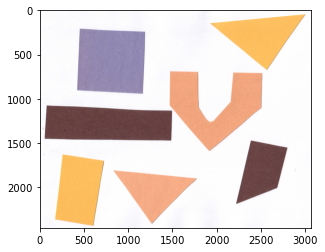

In [10]:
req = urlopen('https://datacarpentry.org/image-processing/fig/07-junk.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img_rgb = cv2.imdecode(arr, -1) # 'Load it as it is'
img = cv2.cvtColor(img_rgb.copy(), cv2.COLOR_BGR2GRAY)

# img = cv2.imread(img_path, 0)
plt.imshow(img_rgb[:,:,::-1])

## Perform edge detection

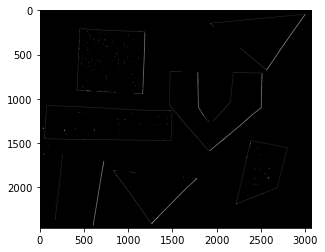

In [11]:
edged = cv2.Canny(img.copy(), 110, 200)
edged = cv2.dilate(edged, None, iterations=2)
edged = cv2.erode(edged, None, iterations=2)
plt.imshow(edged, cmap=cm.gray, vmin=0, vmax=255)


## Perform Line detection

Use Hough Transform (HoughLinesP in OpenCV) to get the endpoints of all lines. They are stored in list ```lines```.

In [12]:
rho = 1  
theta = np.pi / 180  
threshold = 15  
min_line_length = 50  
max_line_gap = 20  
line_image = np.copy(img) * 0  
lines = cv2.HoughLinesP(edged, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)


## Compute Distance of a point from a line

In [13]:
def dot(v, w):
    x, y = v
    X, Y = w
    return x*X + y*Y


def length(v):
    x, y = v
    return math.sqrt(x*x + y*y)


def vector(b, e):
    x, y = b
    X, Y = e
    return (X-x, Y-y)


def unit(v):
    x, y = v
    mag = length(v)
    return (x/mag, y/mag)


def distance(p0, p1):
    return length(vector(p0, p1))


def scale(v, sc):
    x, y = v
    return (x * sc, y * sc)


def add(v, w):
    x, y = v
    X, Y = w
    return (x+X, y+Y)


def pnt2line(pnt, start, end):
    # create a line segment vector
    line_vec = vector(start, end)
    # create a vector from pnt to start
    pnt_vec = vector(start, pnt)
    # compute length of line vector
    line_len = length(line_vec)
    # create unit vector
    line_unitvec = unit(line_vec)
    # project pnt_vec to line_len
    pnt_vec_scaled = scale(pnt_vec, 1.0/line_len)
    # take dot product
    t = dot(line_unitvec, pnt_vec_scaled)
    if t < 0.0:
        t = 0.0
    elif t > 1.0:
        t = 1.0
    nearest = scale(line_vec, t)
    dist = distance(nearest, pnt_vec)
    return dist


## Find distance of closest edge

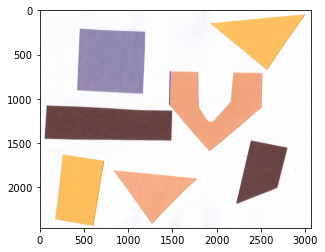

In [14]:
pixel = (1500, 1000)
min_dist = sys.maxsize + 1

img_point = cv2.circle(img_rgb.copy(), pixel, radius=5,
                       color=(0, 0, 255), thickness=-8)

for line in lines:
    for x1, y1, x2, y2 in line:
        p1 = np.asarray((x1, y1))
        p2 = np.asarray((x2, y2))
        p3 = np.asarray(pixel)
        d = pnt2line(pixel, p1, p2)
        if d < min_dist:
            min_dist = d
            reqd_line = [x1, y1, x2, y2]

        elif d == min_dist:
            curr_len = (x1-x2)**2 + (y1-y2)**2
            min_len = (reqd_line[0] - reqd_line[2])**2+(reqd_line[1] - reqd_line[3])**2
            if curr_len >= min_len:
                reqd_line = [x1, y1, x2, y2]


img_point = cv2.circle(img_rgb.copy(), pixel, radius=5,
                       color=(0, 0, 255), thickness=-8)

cv2.line(img_point, (reqd_line[0], reqd_line[1]),
         (reqd_line[2], reqd_line[3]), (255, 0, 0), 5)

plt.imshow(img_point[:,:,::-1])


In [15]:
print("Nearest edge is {:.3f} pixels aways from {}".format(min_dist, pixel))


Nearest edge is 38.671 pixels aways from (1500, 1000)
